In [ ]:
import json
import html
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

nltk.download('stopwords')

def preprocess_text(text):
    text = html.unescape(text) 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower().strip() 
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words]) 
    return text

class TextDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=512):
        self.data = []
        with open(file_path, "r") as f:
            for line in f:
                item = json.loads(line.strip())
                item["text"] = preprocess_text(item["text"])
                self.data.append(item)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(
            item["text"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(item["label"], dtype=torch.long),
        }

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
base_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

class DistilBertClassifier(nn.Module):
    def __init__(self, base_model, num_labels=2):
        super(DistilBertClassifier, self).__init__()
        self.distilbert = base_model
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token's representation
        return logits






model = DistilBertClassifier(base_model).to("cuda" if torch.cuda.is_available() else "cpu")


train_dataset = TextDataset("train/train_short.jsonl", tokenizer)
val_dataset = TextDataset("val/val_short.jsonl", tokenizer)
test_dataset = TextDataset("test/test_short.jsonl", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

def train_model(model, train_loader, val_loader, epochs=5, lr=5e-5):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {train_accuracy:.4f}")

        evaluate_model(model, val_loader)

def evaluate_model(model, loader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

train_model(model, train_loader, val_loader, epochs=5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhyey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/5:   0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\dhyey\anaconda3\envs\cudatest\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:403: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1, Loss: 87.2098, Accuracy: 0.9279
Accuracy: 0.9730, Precision: 0.9721, Recall: 0.9740, F1-Score: 0.9730


Epoch 2/5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2, Loss: 19.1207, Accuracy: 0.9875
Accuracy: 0.9740, Precision: 0.9759, Recall: 0.9720, F1-Score: 0.9739


Epoch 3/5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3, Loss: 7.9550, Accuracy: 0.9945
Accuracy: 0.9680, Precision: 0.9795, Recall: 0.9560, F1-Score: 0.9676


Epoch 4/5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4, Loss: 7.7820, Accuracy: 0.9951
Accuracy: 0.9770, Precision: 0.9649, Recall: 0.9900, F1-Score: 0.9773


Epoch 5/5:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5, Loss: 2.7151, Accuracy: 0.9981
Accuracy: 0.9730, Precision: 0.9665, Recall: 0.9800, F1-Score: 0.9732


Test Dataset Metrics:
Accuracy: 0.7800
Precision: 0.8043
Recall: 0.7400
F1-Score: 0.7708
Confusion Matrix:
[[410  90]
 [130 370]]


C:\Users\dhyey\AppData\Local\Temp\ipykernel_144\3923604537.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


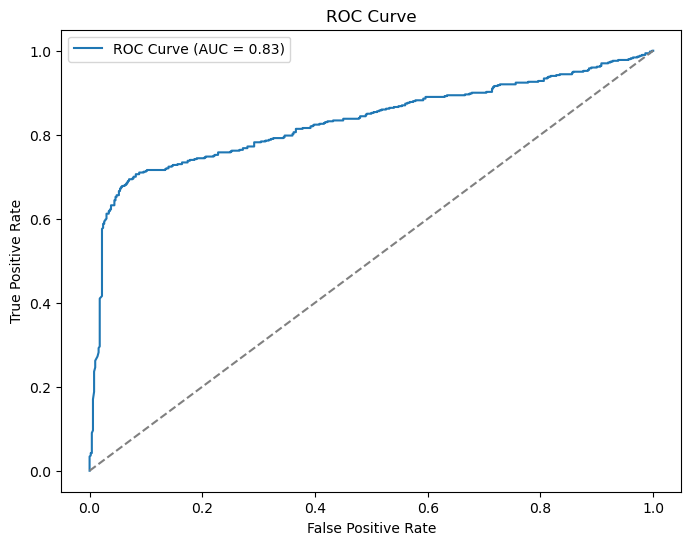

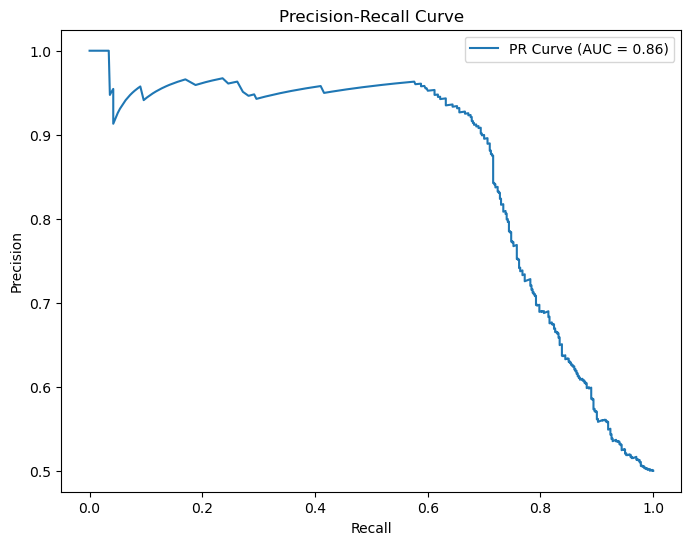

In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Dataset Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    #ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    #P-R
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f"PR Curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    pr_data = pd.DataFrame({'Recall': recall_curve, 'Precision': precision_curve})
    
    roc_data.to_csv('roc_curve_distil.csv', index=False)
    pr_data.to_csv('pr_curve_distil.csv', index=False)

evaluate_on_test(model, test_loader)


In [ ]:
# Class	Precision	Recall	F1 Score
# Human	0.759	0.820	0.789
# Machine	0.804	0.740	0.771